In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, balanced_accuracy_score, confusion_matrix, RocCurveDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
import sys

file_path = "https://raw.githubusercontent.com/FarzinSohraby/PathInHydro/refs/heads/main/"

pd.set_option('display.precision', 2)

Mounted at /content/gdrive


In [ ]:
data = pd.read_csv(file_path+'Df_H2ase_CO_H2.csv')
data.shape


# Add a 'Molecule' column to distinguish CO and H2 based on the 'Trajectory' column
data['Molecule'] = data['Trajectory'].apply(lambda x: 'H2' if 'H2' in x else 'CO')


data = data.drop(["Trajectory", "Frame", "Pathway-new"], axis=1)

X = data.drop(['Binary', "Molecule"], axis=1)  # Features
y = data['Binary']  # Target variable


# Perform stratified train/validation/test split based on 'Molecule' column to ensure a consistent ratio between CO and H2
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=data['Molecule']
)

# Now split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1, stratify=data.loc[y_temp.index, 'Molecule']
)

# oversample the trainin set
oversampler = RandomOverSampler(random_state=1)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
data.shape

(899, 806)

In [ ]:
# Calculate distribution percentages for the entire dataset
total_distribution = data['Molecule'].value_counts(normalize=True) * 100
print("Overall Distribution (%):\n", total_distribution)

# Calculate distribution in each set
train_distribution = data.loc[X_train.index, 'Molecule'].value_counts(normalize=True) * 100
val_distribution = data.loc[X_val.index, 'Molecule'].value_counts(normalize=True) * 100
test_distribution = data.loc[X_test.index, 'Molecule'].value_counts(normalize=True) * 100

print("\nTraining Set Distribution (%):\n", train_distribution)
print("\nValidation Set Distribution (%):\n", val_distribution)
print("\nTest Set Distribution (%):\n", test_distribution)


Overall Distribution (%):
 Molecule
CO    91.77
H2     8.23
Name: proportion, dtype: float64

Training Set Distribution (%):
 Molecule
CO    91.73
H2     8.27
Name: proportion, dtype: float64

Validation Set Distribution (%):
 Molecule
CO    91.85
H2     8.15
Name: proportion, dtype: float64

Test Set Distribution (%):
 Molecule
CO    91.85
H2     8.15
Name: proportion, dtype: float64


In [ ]:
data = pd.read_csv(file_path+'Df_H2ase_O2.csv')
data = data.drop(["Trajectory", "Frame", "Pathway-new"], axis=1)

X_O2 = data.drop('Binary', axis=1)  # Features
y_O2 = data['Binary']  # Target variable

In [ ]:
data = pd.read_csv(file_path+'Mdg_H2ase_CO.csv')
data = data.drop(["Trajectory", "Frame", "Pathway-new"], axis=1)

X_Mdg_CO = data.drop('Binary', axis=1)  # Features
y_Mdg_CO = data['Binary']  # Target variable

In [ ]:
data = pd.read_csv(file_path+'Mdg_H2ase_H2.csv')
data = data.drop(["Trajectory", "Frame", "Pathway-new"], axis=1)

X_Mdg_H2 = data.drop('Binary', axis=1)  # Features
y_Mdg_H2 = data['Binary']  # Target variable

In [ ]:
data = pd.read_csv(file_path+'Mdg_H2ase_O2.csv')
data = data.drop(["Trajectory", "Frame", "Pathway-new"], axis=1)

X_Mdg_O2 = data.drop('Binary', axis=1)  # Features
y_Mdg_O2 = data['Binary']  # Target variable

In [ ]:
# customized function to calculate the predictions and metrics
def calc_metrics(y, y_pred):
    acc = accuracy_score(y, y_pred)
    ba = balanced_accuracy_score(y, y_pred)
    mcc = matthews_corrcoef(y, y_pred)
    cm = confusion_matrix(y, y_pred, labels=["Primary","Secondary"])
    return(acc, ba, mcc, cm)

# customized function to plot the confusion matrices
def plot_heatmap(cm, classes, title, ax=None, adjust_yticks=False):
    if not ax:
        _, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True, ax=ax,
                xticklabels=classes, yticklabels=classes, annot_kws={"fontsize":11, "fontweight":"bold"})
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Observed', fontsize=12)
    if adjust_yticks:
        ax.tick_params(axis='y', rotation=90)
    ax.set_title(title, fontsize=14)

In [ ]:
ada = AdaBoostClassifier(n_estimators=500, learning_rate=0.05, random_state=1)

ada.fit(X_train_resampled, y_train_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(learning_rate=0.05, n_estimators=500, random_state=1)

In [ ]:
# calculate and display the results
ds_names = ["Df-H$_2$ase-CO/Df-H$_2$ase-H$_2$\nTraining Set", "Df-H$_2$ase-CO/Df-H$_2$ase-H$_2$\nValidation Set", "Df-H$_2$ase-CO/Df-H$_2$ase-H$_2$\nTest ", "Df-H$_2$ase-O$_2$-test", "Mdg-H$_2$ase-CO-test", "Mdg-H$_2$ase-H$_2$-test", "Mdg-H$_2$ase-O$_2$-test"]
ds_names_formatted = ['Training Set', 'Validation Set', 'Df-H$_2$ase-CO/Df-H$_2$ase-H$_2$\nTest Set', 'Df-H$_2$ase-O$_2$ Test Set','Mdg-H$_2$ase-CO Test Set','Mdg-H$_2$ase-H$_2$ Test Set','Mdg-H$_2$ase-O$_2$ Test Set']
ds_names_table = ['Df-H2ase-CO/Df-H2ase-H2 Training Set', 'Df-H2ase-CO/Df-H2ase-H2 Validation Set', 'Df-H2ase-CO/Df-H2ase-H2 Test Set', 'Df-H2ase-O2 Test Set','Mdg-H2ase-CO Test Set','Mdg-H2ase-H2 Test Set','Mdg-H2ase-O2 Test Set']

ds_features = [X_train, X_val, X_test, X_O2, X_Mdg_CO, X_Mdg_H2, X_Mdg_O2]
ds_target = [y_train, y_val, y_test, y_O2, y_Mdg_CO, y_Mdg_H2, y_Mdg_O2]

results_dict = {}

for i in range(len(ds_names)):
    y_pred = ada.predict(ds_features[i])
    acc, ba, mcc, cm = calc_metrics(ds_target[i], y_pred)
    results_dict[ds_names_table[i]] = [y_pred, acc, ba, mcc, cm]

results_df = pd.DataFrame.from_dict(results_dict, orient="index",
                                    columns=["predictions", "accuracy", "BA", "MCC", "CM"])

display(results_df.loc[:,["accuracy", "BA", "MCC"]])

,accuracy,BA,MCC
Df-H2ase-CO/Df-H2ase-H2 Training Set,0.98,0.97,0.94
Df-H2ase-CO/Df-H2ase-H2 Validation Set,0.97,0.98,0.91
Df-H2ase-CO/Df-H2ase-H2 Test Set,0.89,0.87,0.71
Df-H2ase-O2 Test Set,0.72,0.84,0.47
Mdg-H2ase-CO Test Set,0.97,0.99,0.85
Mdg-H2ase-H2 Test Set,0.84,0.84,0.67
Mdg-H2ase-O2 Test Set,0.84,0.72,0.41


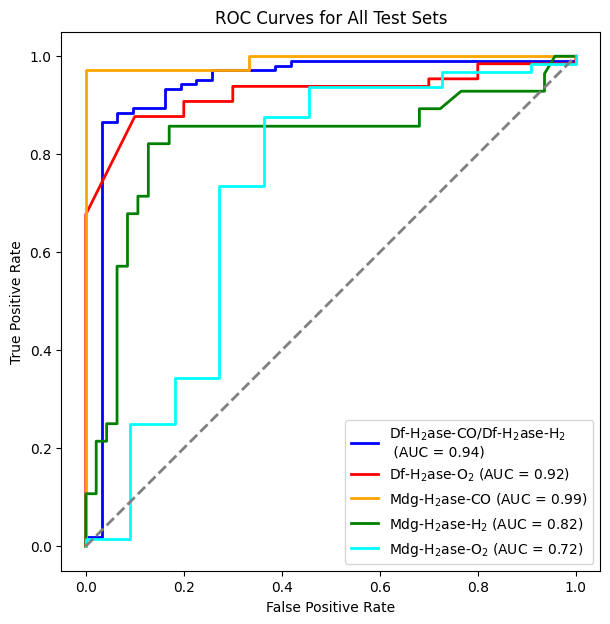

In [ ]:
roc_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
colors = [None, None, 'blue', 'red', 'orange', 'green', 'cyan']

for i in range(2,7):
    RocCurveDisplay.from_estimator(ada, ds_features[i], ds_target[i], pos_label="Primary", ax=ax,
                                   name=ds_names[i][:-5], color=colors[i], lw=2)

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')

# Adjust limits to add padding around the edges
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Test Sets')
plt.legend(loc="lower right")

#plt.savefig(file_path+'ROC-test-All.jpg', dpi=300, format='jpg')
plt.show()

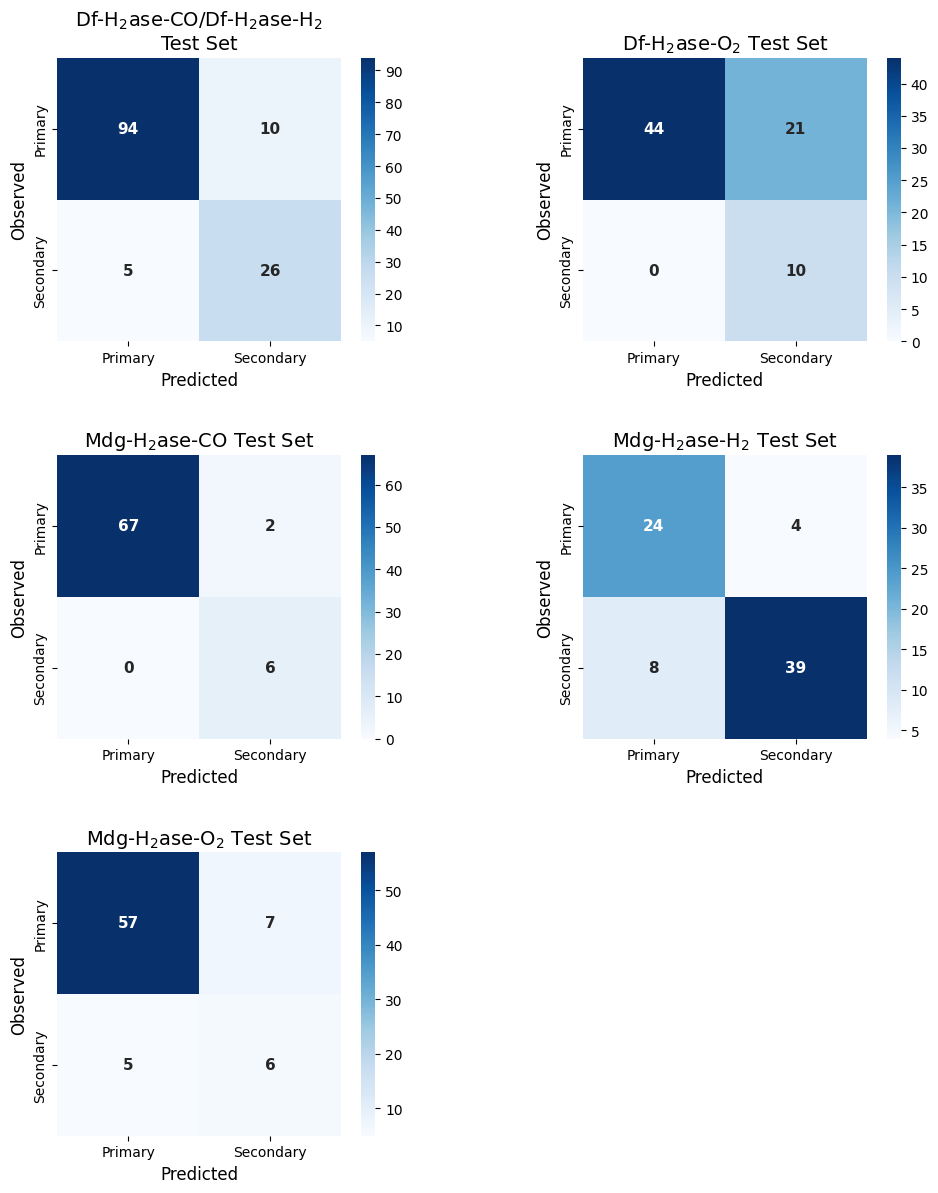

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))

fig.delaxes(axes[2, 1])

k = 0
for i, j in np.ndindex(axes.shape):
    ax = axes[i, j]

    if k + 2 < len(results_df) and k + 2 < len(ds_names_formatted) and (i, j) != (2, 1):
        plot_heatmap(results_df.iloc[k + 2, -1], ['Primary', 'Secondary'], ds_names_formatted[k + 2],
                     ax, adjust_yticks=True)
        k += 1
    else:
        continue

for ax in axes.flat:
    if ax is not None:
        ax.set_aspect('equal')
        ax.set_position(ax.get_position().translated(0, 0.05))
        ax.set_position(ax.get_position().shrunk(0.95, 0.95))


plt.subplots_adjust(wspace=0.3, hspace=0.4)
#plt.savefig(file_path+'CM-Binary.jpg', dpi=600, format='jpg')
plt.show()

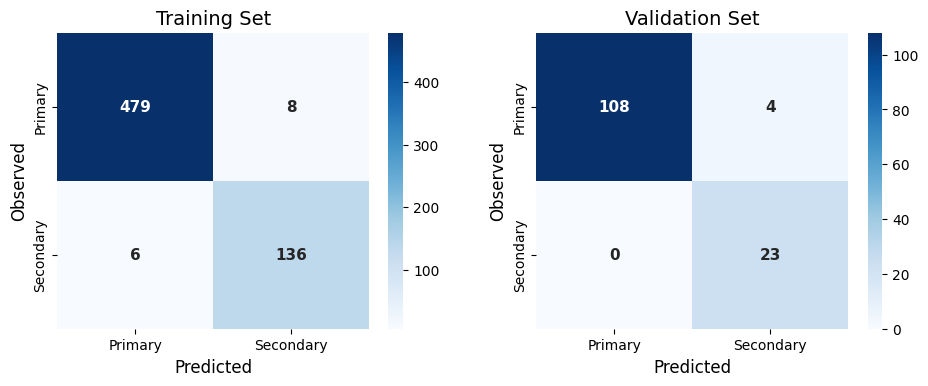

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.5))

for i in range(2):
    # fetch the subplot
    ax = axes[i]
    plot_heatmap(results_df.iloc[i,-1], ['Primary','Secondary'], ds_names_formatted[i],
                 ax, adjust_yticks=True)
plt.tight_layout(pad=3)
#plt.savefig(file_path+'CM-train-val-Binary.jpg', dpi=600, format='jpg')
plt.show()

In [ ]:
# Instantiate the DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=1)

# Fit the model on the resampled training data
dummy_clf.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred_dummy = dummy_clf.predict(X_test)

# Assess accuracy on the test set
balanced_accuracy_test_dummy = balanced_accuracy_score(y_test, y_pred_dummy)
mcc_test_dummy = matthews_corrcoef(y_test, y_pred_dummy)

print(f'Baseline (Dummy Classifier) Balanced Accuracy on the test set: {balanced_accuracy_test_dummy:.2f}')
print(f'Baseline (Dummy Classifier) Matthews Correlation Coefficient on the test set: {mcc_test_dummy:.2f}')

# Predict on the training set
y_pred_train_dummy = dummy_clf.predict(X_train)

# Assess accuracy on the training set
balanced_accuracy_train_dummy = balanced_accuracy_score(y_train, y_pred_train_dummy)
mcc_train_dummy = matthews_corrcoef(y_train, y_pred_train_dummy)

print(f'Baseline (Dummy Classifier) Balanced Accuracy on the training set: {balanced_accuracy_train_dummy:.2f}')
print(f'Baseline (Dummy Classifier) Matthews Correlation Coefficient on the training set: {mcc_train_dummy:.2f}')


Baseline (Dummy Classifier) Balanced Accuracy on the test set: 0.50
Baseline (Dummy Classifier) Matthews Correlation Coefficient on the test set: 0.00
Baseline (Dummy Classifier) Balanced Accuracy on the training set: 0.50
Baseline (Dummy Classifier) Matthews Correlation Coefficient on the training set: 0.00


In [ ]:
y_train_scrambled = shuffle(y_train, random_state=1)
X_train_scram_resampled, y_train_scram_resampled = oversampler.fit_resample(X_train, y_train_scrambled)

ada_scram = ada = AdaBoostClassifier(n_estimators=500, learning_rate=0.05, random_state=1)

ada_scram.fit(X_train_scram_resampled, y_train_scram_resampled)

# Predict on the training set with scrambled labels
y_pred_train_scrambled = ada_scram.predict(X_train)
y_scram_pred_test = ada_scram.predict(X_test)

# Assess accuracy on the training set with scrambled labels
balanced_accuracy_train_scrambled = balanced_accuracy_score(y_train_scrambled, y_pred_train_scrambled)
mcc_train_scrambled = matthews_corrcoef(y_train_scrambled, y_pred_train_scrambled)
balanced_accuracy_test_scrambled = balanced_accuracy_score(y_test, y_scram_pred_test)
mcc_test_scrambled = matthews_corrcoef(y_test, y_scram_pred_test)

print(f'Scrambled Balanced Accuracy on the training set: {balanced_accuracy_train_scrambled:.2f}')
print(f'Scrambled Matthews Correlation Coefficient on the training set: {mcc_train_scrambled:.2f}')
print(f'Scrambled Balanced Accuracy on the test set: {balanced_accuracy_test_scrambled:.2f}')
print(f'Scrambled Matthews Correlation Coefficient on the test set: {mcc_test_scrambled:.2f}')

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Scrambled Balanced Accuracy on the training set: 0.83
Scrambled Matthews Correlation Coefficient on the training set: 0.59
Scrambled Balanced Accuracy on the test set: 0.49
Scrambled Matthews Correlation Coefficient on the test set: -0.01


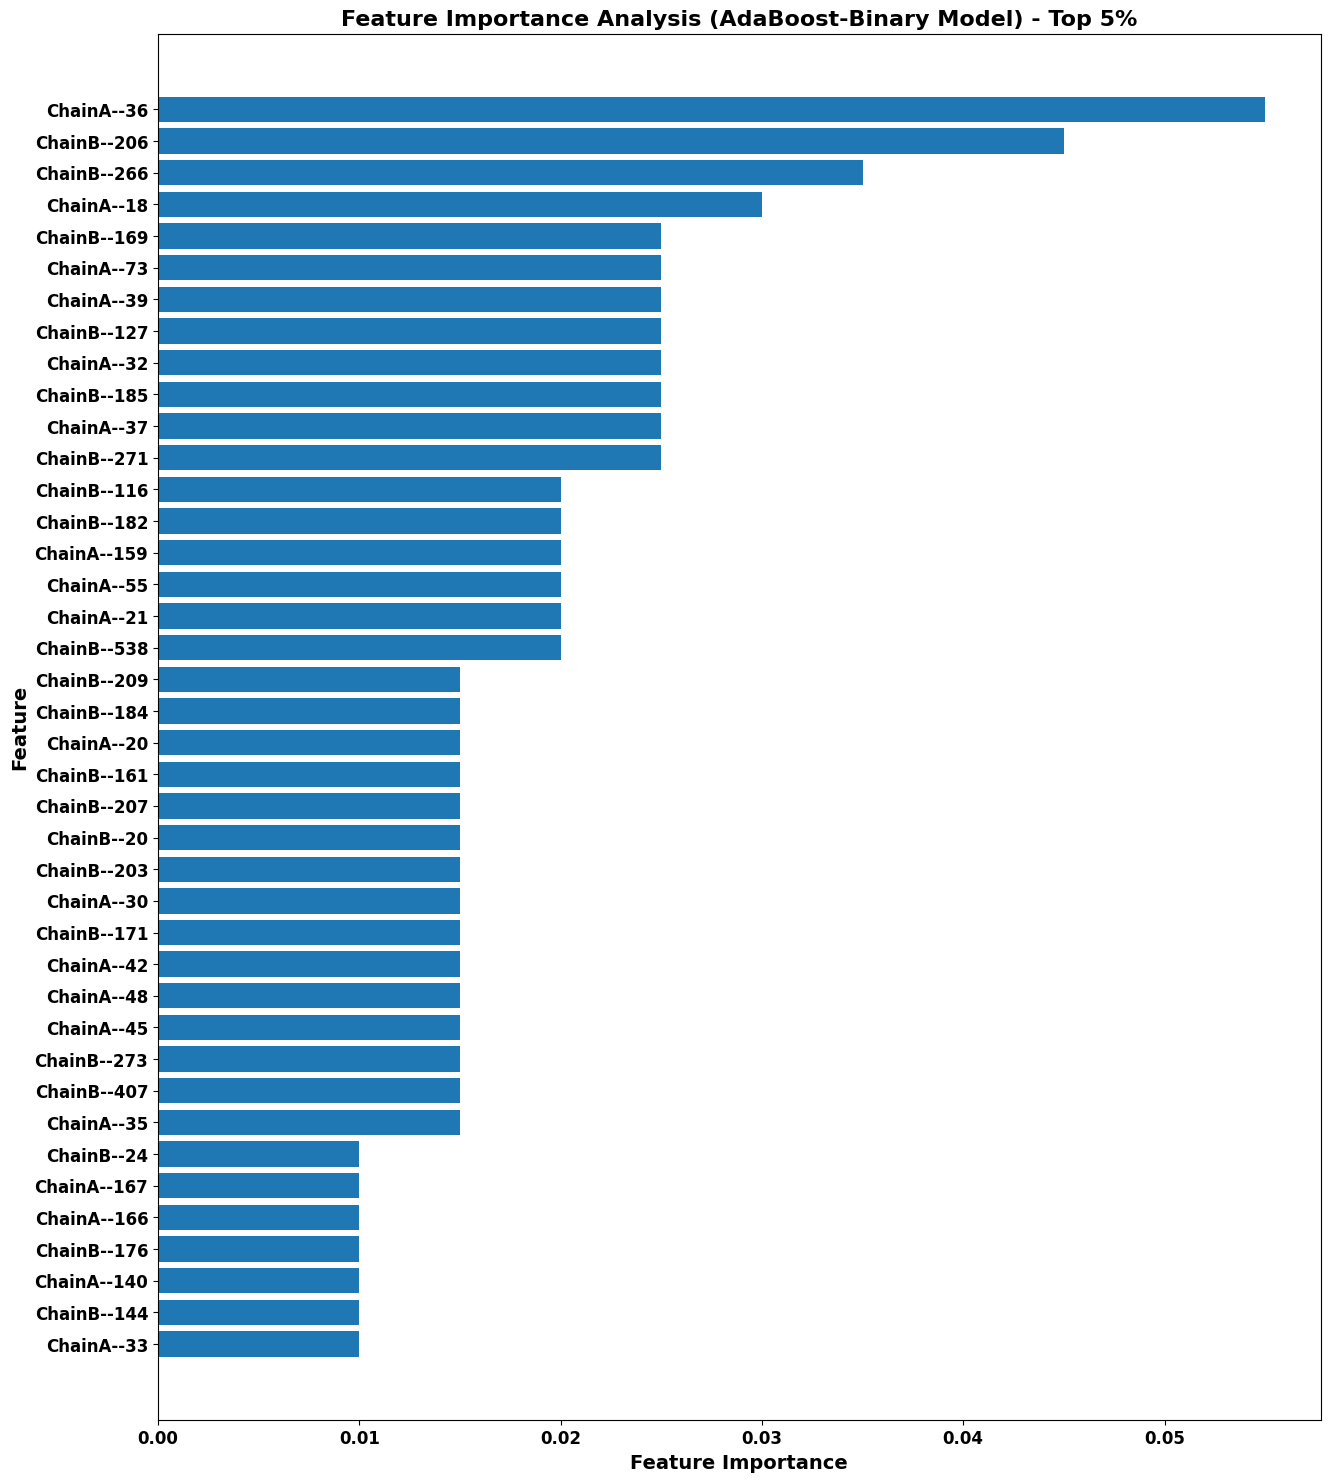

In [ ]:
feature_importances = ada.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

num_top_features = int(len(feature_importance_df) * 0.05)
top_feature_importance_df = feature_importance_df.head(num_top_features)

plt.figure(figsize=(15, 18))
plt.barh(top_feature_importance_df['Feature'], top_feature_importance_df['Importance'])

plt.xlabel('Feature Importance', fontsize=14, fontweight='bold')
plt.ylabel('Feature', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('Feature Importance Analysis (AdaBoost-Binary Model) - Top 5%', fontsize=16, fontweight='bold')

plt.gca().invert_yaxis()
#plt.savefig(file_path+'Feature-Importance-Binary.jpg', dpi=300, format='jpg')
plt.show()
